# Importing Packages + Mount Drive

All packages necessary for the visualisation of the data must be imported here.
As mentioned in the ReadMe File, you should have put all the data in your drive in a file called 'CSS 433 / data '. If this is not done, this code will not be able to run properly. If you would like to deposit your data somewhere else, please feel free to change the code according to your needs.


In [1]:
#importing packages
import numpy as np
import pandas as pd
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import h5py
import sys
import datetime
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.layers import Conv2D, LSTM, Flatten, BatchNormalization, TimeDistributed, Dense, \
MaxPooling2D, GlobalMaxPooling2D, Dropout, Reshape, concatenate, Flatten, Input, LocallyConnected2D
from tensorflow.keras.utils import Sequence
import cv2


from google.colab import files ### file.download() to download a file from colab instead of right clicking

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.utils.data.sampler import SequentialSampler
from torchvision import transforms, utils
import cv2
import seaborn as sns
from datetime import datetime


The cell below mounts the drive giving access to the data for this project.

In [3]:
#Mounting Drive
from google.colab import drive
# # # # This will prompt for authorization.
drive.mount("/content/drive")

## change path to where the folder of the images is
path = '/content/drive/MyDrive/CSS 433/data'
for file in os.listdir(path):
  print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time.npy
new_irradiance.xlsx
ground_truth.npy
labels.npy
persistent_level.npy
meteo.xlsx
X.npy


# Importing Data
First, make sure you create a class that loads the images and their corresponding labels.

In [4]:
class GHIDataset(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, transform_input=None, transform_label=None):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            transform_input (callable, optional): Optional transform to be applied on a sample. .
            transform_label (callable, optional): Optional transform to be applied on the label.
        """

        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels)))
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')

        # Define the transforms to apply to labels or input
        self.transform_input = transform_input
        self.transform_label = transform_label


    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Import from memory only the images that we want
        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        # Apply the transforms
        if self.transform_input:
            image0 = self.transform_input(image0)
            image1 = self.transform_input(image1)

        if self.transform_label:
            labels = self.transform_label(labels)

        # Returns the sample as a tuple of (image0, image1, labels)
        return image0,image1,labels

Then load additional data such as the time of the images, their ground_truth and define their labels from the dataset.
We furthermore have meteo data which consists of time, date, wind direction, wind speed and temperature.

In [5]:
img_size = 100

# Create a transform, it converts the np.array to a PIL Image,
# then resize the image to img_size x img_size, then converts the image to tensor

transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize(img_size),transforms.ToTensor()])

# Creates the dataset containing all the samples
ghi_dataset = GHIDataset(path,'labels.npy','X.npy',transform)


In [6]:
# IMAGE DATA
time_image = np.load(os.path.join(path, 'time.npy'),allow_pickle=True)
ground_truth = np.load(os.path.join(path, 'ground_truth.npy'),allow_pickle=True)
labels = ghi_dataset.labels
# Extract day, month, and year using list comprehension
date_info_image = [(dt.day, dt.month, dt.year) if isinstance(dt, datetime) else
                   (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
                    datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
                    datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year)
                   for dt in time_image]

# List comprehension to extract day values for all dates
day_values_image = [day for day, _, _ in date_info_image]
month_values_image = [month for _, month, _ in date_info_image]
year_values_image = [year for _ , _, year in date_info_image]
month_and_year_values_image = [(month, year) for _, month, year in date_info_image]

# METEO DATA
# Construct the full path to the Excel file
file_path = os.path.join(path, 'meteo.xlsx')
# Use pandas to read the Excel file
df = pd.read_excel(file_path)

date = df['Date'].values
time_meteo = df['Time'].values
real_time_ch = df['Real_time_CH'].values
air_temp = df['Air_temp'].values
wind_speed = df['Wind_speed'].values
wind_dir = df['Wind_dir'].values

# Extract day, month, and year using list comprehension
date_info = [(datetime.strptime(date_, '%d.%m.%Y').day,
              datetime.strptime(date_, '%d.%m.%Y').month,
              datetime.strptime(date_, '%d.%m.%Y').year) for date_ in date]

# List comprehension to extract day values for all dates
day_values_meteo = [day for day, _, _ in date_info]
month_values_meteo = [month for _, month, _ in date_info]
year_values_meteo = [year for _ , _, year in date_info]
month_and_year_values_meteo = [(month, year) for _, month, year in date_info]

# Data Visualisation


In [7]:
def sample_display(image1,image2, label):
  # The image is a now a Torch vector, it needs to be reshaped for display
  plt.imshow(image1.permute(1,2,0))
  print("Label : ", label.item())

## Images

Label :  133.0
Label :  127.0
Label :  140.0
Label :  141.0


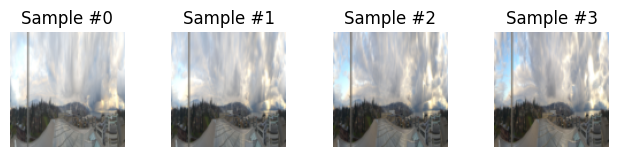

In [8]:
sample_size = 4

for i, sample in enumerate(ghi_dataset):
    #print(i, sample[0].shape, sample[1].shape, sample[2].shape)

    ax = plt.subplot(1, sample_size, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    sample_display(*sample)

    if i == (sample_size-1):
      plt.savefig('images.png')
      #files.download('images.png') # Save the plot in your download
      plt.show()
      break

## GHI Labels (two hours later)

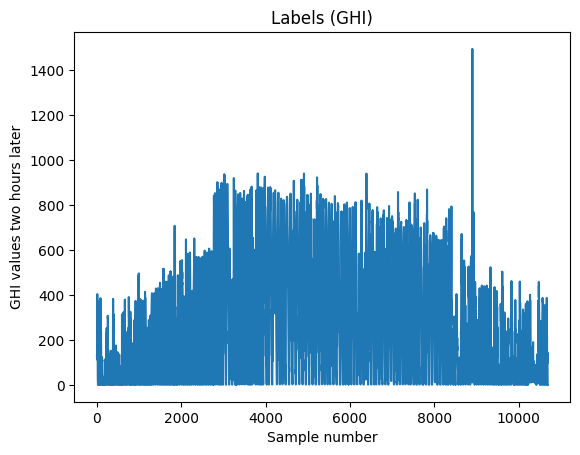

In [9]:
plt.plot(labels)#,marker='o', linestyle='None')
plt.title('Labels (GHI)')
plt.xlabel('Sample number')
plt.ylabel('GHI values two hours later')
plt.savefig('labels_plot.png')
# files.download('labels_plot.png') # Save the plot in your download

This plot seems to show an outlier. Below, we computed the sample number corresponding to that outlier and then checked at the values around it which confirms that it was not a slow increase. We therefore might need to remove it.

In [10]:
np.where(labels >1400)

(array([8902]),)

In [11]:
print(real_time_ch[8901], labels[8901].item(), end=',\n')
print(real_time_ch[8902], labels[8902].item(), end=',\n')
print(real_time_ch[8903], labels[8903].item())

2022-10-10T16:50:00.000000000 79.0,
2022-10-10T17:00:00.000000000 1493.0,
2022-10-10T17:10:00.000000000 555.0


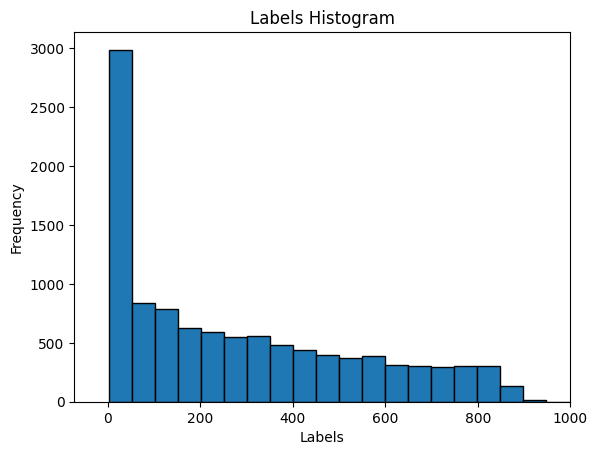

In [12]:
plt.hist(ghi_dataset.labels, bins = 30, edgecolor='black')
plt.xlim(right=1000) # This aims at removing the outlier for a better overview
plt.title('Labels Histogram')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.savefig('labels_his.png')
#files.download('labels_his.png') # Save the plot in your download

## Ground Truth

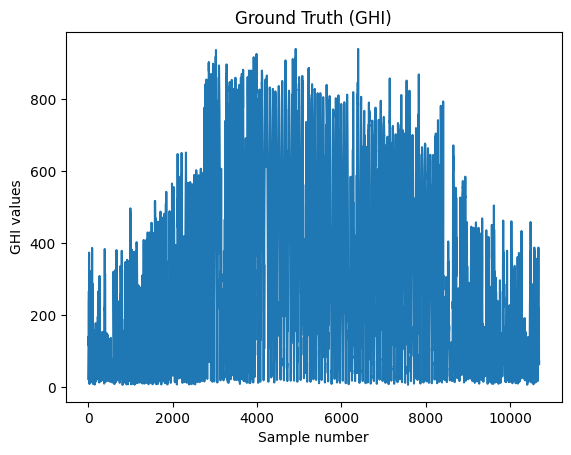

In [13]:
plt.plot(ground_truth)
plt.title('Ground Truth (GHI)')
plt.xlabel('Sample number')
plt.ylabel('GHI values')
plt.savefig('ground_truth_plot.png')
#files.download('ground_truth_plot.png') # Save the plot in your download

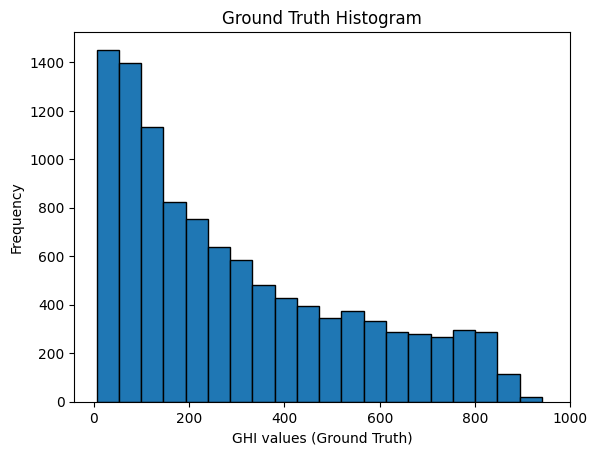

In [14]:
plt.hist(ground_truth, bins = 20, edgecolor = 'black')
plt.xlim(right=1000)
plt.title('Ground Truth Histogram')
plt.xlabel('GHI values (Ground Truth)')
plt.ylabel('Frequency')
plt.savefig('ground_truth_his.png')
#files.download('ground_truth_his.png') # Save the plot in your download

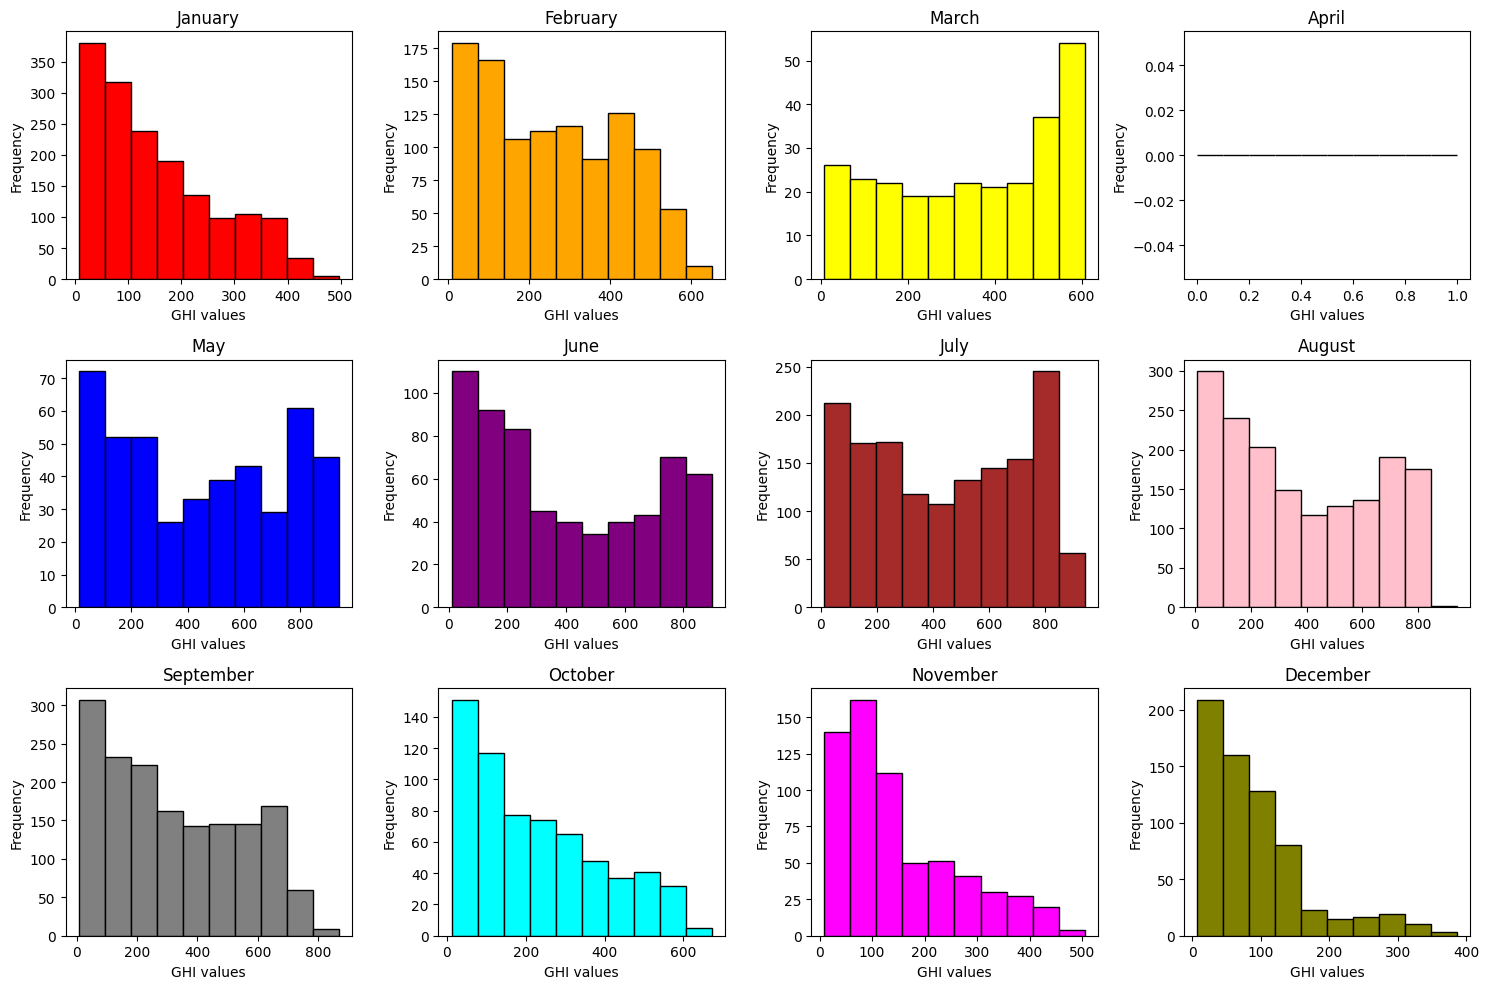

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Make a list of all the titles / months
title = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Define a set of colors for each month
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive']

# Create a single figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 months

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define the titles of the files to save each image
files_title = ['GHI_January.png', 'GHI_February.png', 'GHI_March.png', 'GHI_April.png', 'GHI_May.png', 'GHI_June.png', 'GHI_July.png', 'GHI_August.png', 'GHI_September.png', 'GHI_October.png', 'GHI_November.png', 'GHI_December.png']

for i in range(1, 13):
    # Filter data for the current month
    GHI_month = ground_truth[np.where(np.isclose(month_values_meteo, i))]

    # Plot on the corresponding subplot
    axes[i-1].hist(GHI_month, color=colors[i-1], edgecolor='black')
    axes[i-1].set_title(title[i-1])
    axes[i-1].set_xlabel('GHI values')
    axes[i-1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Save the entire figure
plt.savefig('GHI_AllMonths.png')
plt.show()


In [16]:
#files.download('GHI_AllMonths.png')

These graphs show us how much the GHI depends on the month. Since we only have approximately a year's worth of data it is important for us to still train on every month. For the validation set, it might also be wise to take some data from multiple different months. This would allow us not to bias our model towards or away from a certain month. Unfortunatly, we know our model should not be considered to predict very accurate GHI values for the month of April as it has never seen data from this specific month.

## Image Date

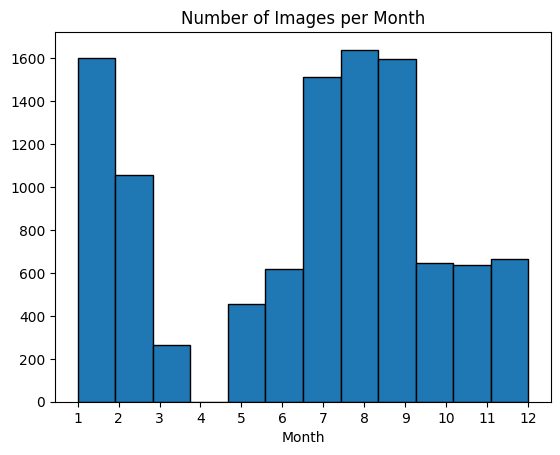

In [17]:
plt.hist(month_values_image, bins = 12, edgecolor = 'black')
plt.title('Number of Images per Month')
plt.xlabel('Month')
plt.xticks(range(1, 13))
plt.savefig('image_date_his.png')
#files.download('image_date_his.png') # Save the plot in your download

We can see from the histogram that there is no data in April. This is due to a fire that happened on campus.

## Meteo Wind

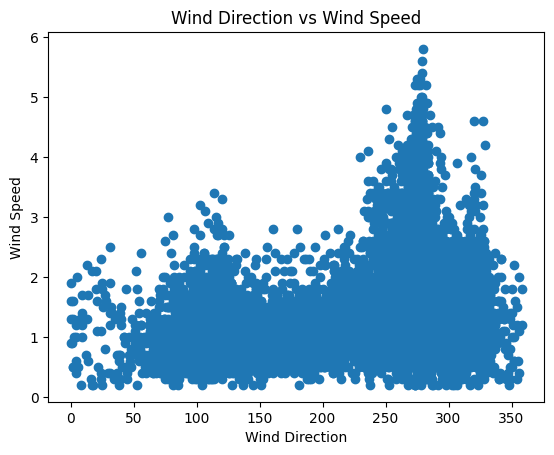

In [18]:
plt.scatter(wind_dir, wind_speed)
plt.title('Wind Direction vs Wind Speed')
plt.xlabel('Wind Direction')
plt.ylabel('Wind Speed')
plt.savefig('meteo_wind_scatter.png')
#files.download('meteo_wind_scatter.png') # Save the plot in your download

We can see from this plot that we have the highest wind speed in the 250-300 wind direction. There does not seem to be many recorded data with a wind direction around 0-50. The question would now be: is there a bias according to the month or can we observe the same distribution all year long?

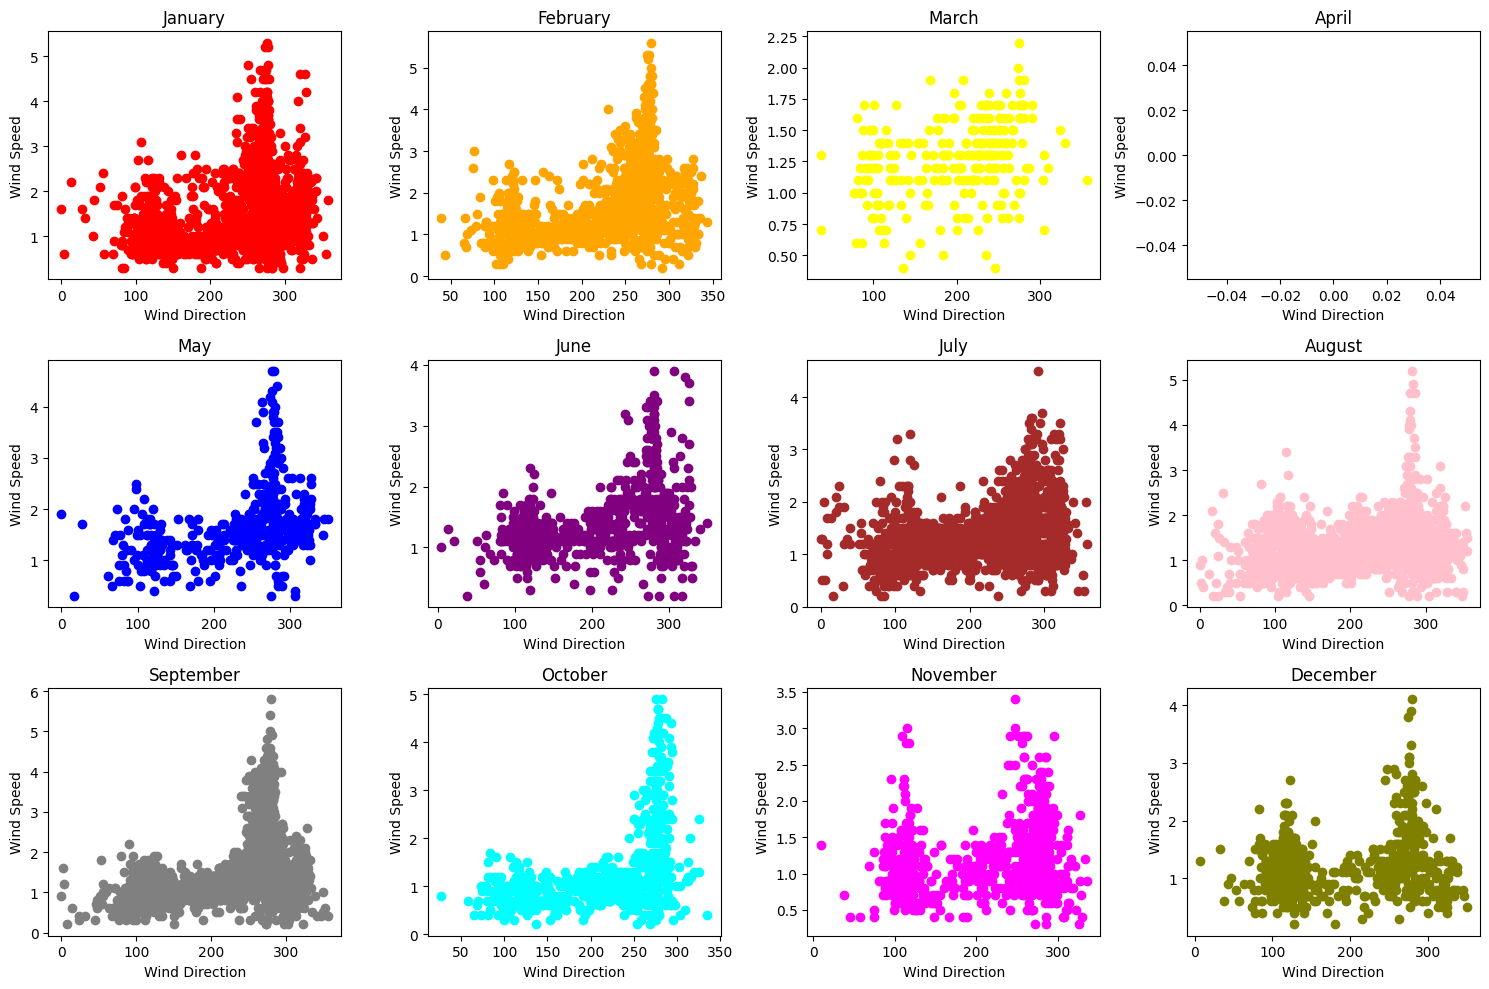

In [19]:
# Make a list of all the titles / months
title = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Define a set of colors for each month
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive']

# Create a single figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 months

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define the titles of the files to save each image
files_title = ['meteo_wind_scatter_January.png', 'meteo_wind_scatter_February.png', 'meteo_wind_scatter_March.png', 'meteo_wind_scatter_April.png', 'meteo_wind_scatter_May.png', 'meteo_wind_scatter_June.png', 'meteo_wind_scatter_July.png', 'meteo_wind_scatter_August.png', 'meteo_wind_scatter_September.png', 'meteo_wind_scatter_October.png', 'meteo_wind_scatter_November.png', 'meteo_wind_scatter_December.png']

for i in range(1, 13):
    # Filter data for the current month
    wind_dir_month = wind_dir[np.where(np.isclose(month_values_meteo, i))]
    wind_speed_month = wind_speed[np.where(np.isclose(month_values_meteo, i))]

    # Plot on the corresponding subplot
    axes[i-1].scatter(wind_dir_month, wind_speed_month, color=colors[i-1])
    axes[i-1].set_title(f'{title[i-1]}')
    axes[i-1].set_xlabel('Wind Direction')
    axes[i-1].set_ylabel('Wind Speed')

# Adjust layout
plt.tight_layout()

# Save the entire figure
plt.savefig('meteo_wind_scatter_AllMonths.png')
plt.show()


In [20]:
#files.download('meteo_wind_scatter_AllMonths.png')

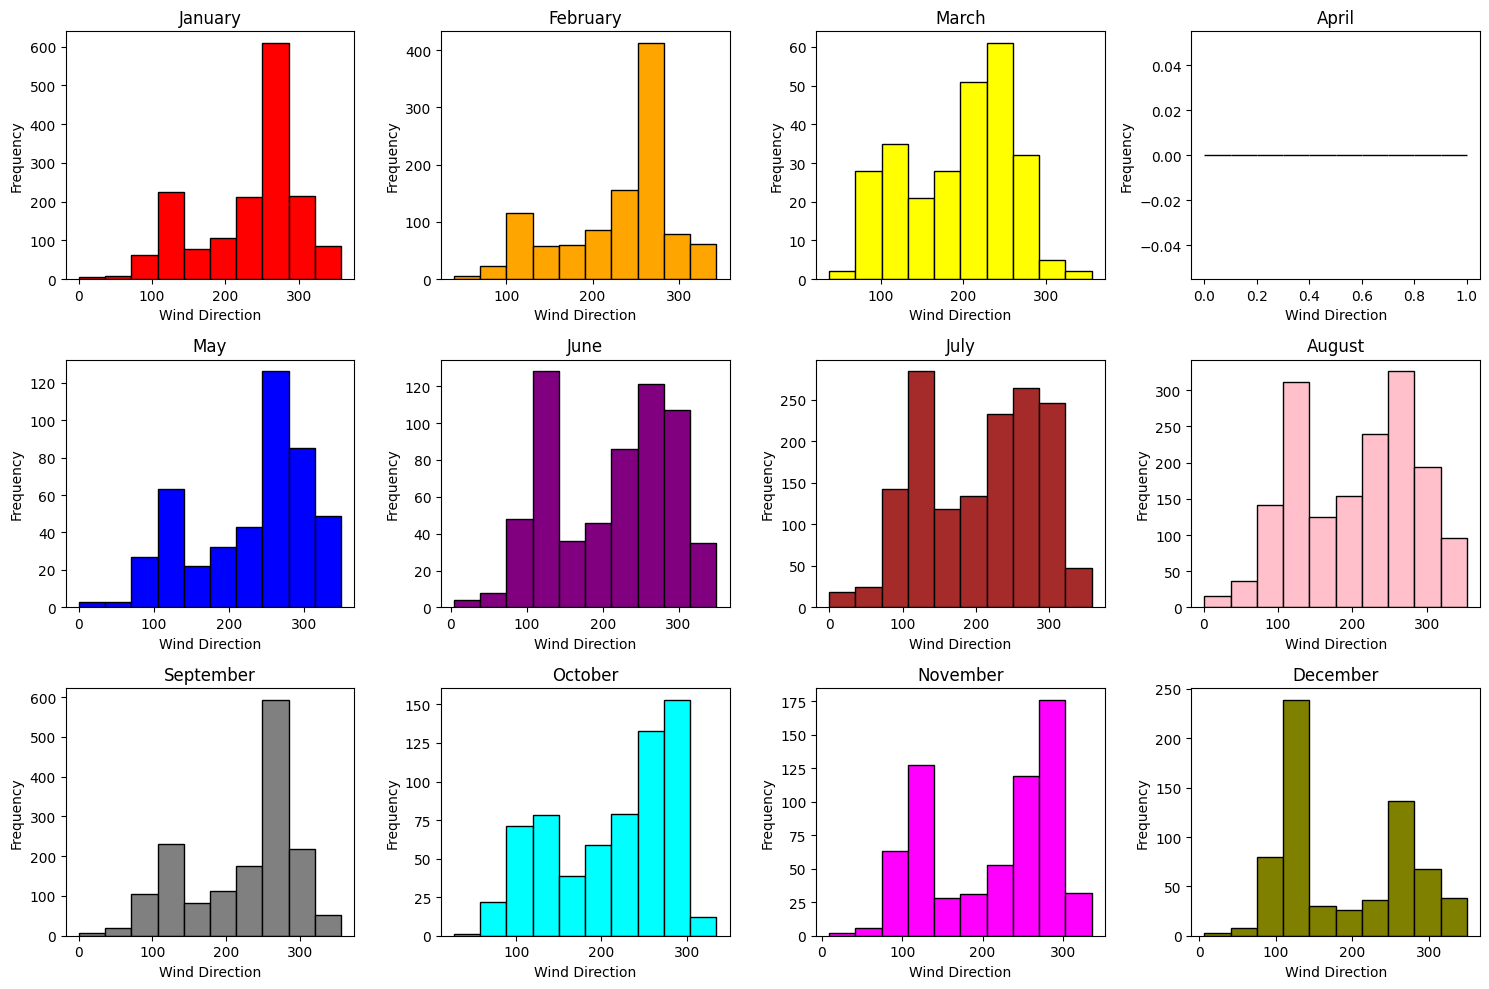

In [21]:
# Make a list of all the titles / months
title = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Define a set of colors for each month
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive']

# Create a single figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 months

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define the titles of the files to save each image
files_title = ['meteo_wind_scatter_January.png', 'meteo_wind_scatter_February.png', 'meteo_wind_scatter_March.png', 'meteo_wind_scatter_April.png', 'meteo_wind_scatter_May.png', 'meteo_wind_scatter_June.png', 'meteo_wind_scatter_July.png', 'meteo_wind_scatter_August.png', 'meteo_wind_scatter_September.png', 'meteo_wind_scatter_October.png', 'meteo_wind_scatter_November.png', 'meteo_wind_scatter_December.png']

for i in range(1, 13):
    # Filter data for the current month
    wind_dir_month = wind_dir[np.where(np.isclose(month_values_meteo, i))]

    # Plot on the corresponding subplot
    axes[i-1].hist(wind_dir_month, color=colors[i-1], edgecolor = 'black')
    axes[i-1].set_title(f'{title[i-1]}')
    axes[i-1].set_xlabel('Wind Direction')
    axes[i-1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Save the entire figure
plt.savefig('wind_dir_AllMonths.png')
plt.show()


In [22]:
#files.download('wind_dir_AllMonths.png')

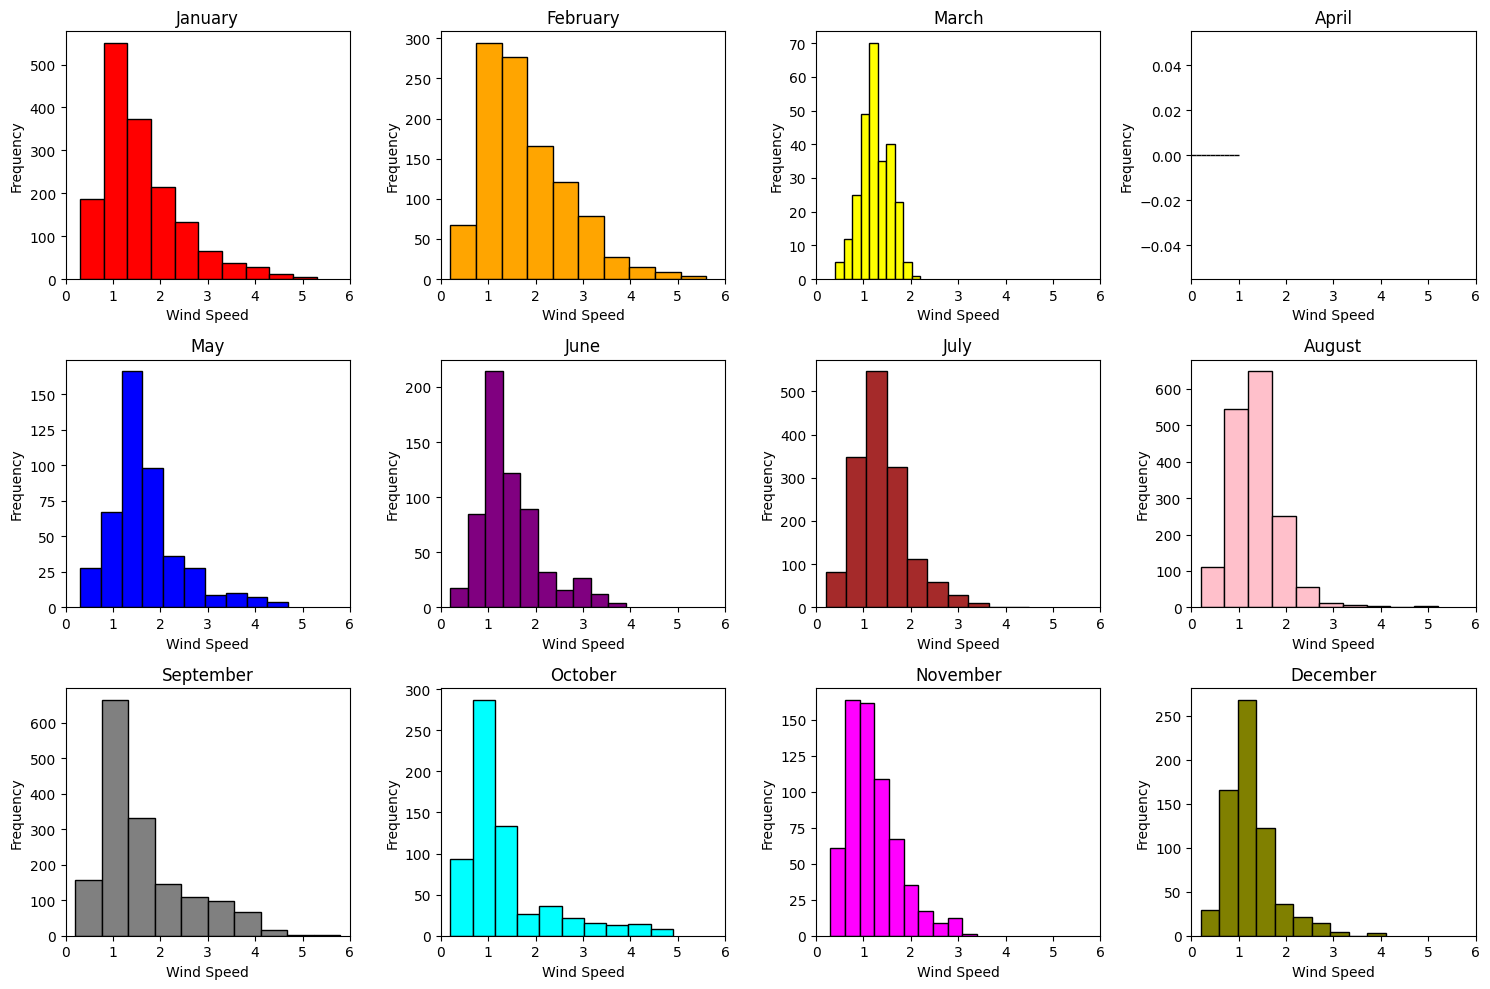

In [23]:
# Make a list of all the titles / months
title = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Define a set of colors for each month
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive']

# Create a single figure with subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 months

# Flatten the axes array for easy iteration
axes = axes.flatten()


for i in range(1, 13):
    # Filter data for the current month
    wind_speed_month = wind_speed[np.where(np.isclose(month_values_meteo, i))]

    # Plot on the corresponding subplot
    axes[i-1].hist(wind_speed_month, color=colors[i-1], edgecolor = 'black')
    axes[i-1].set_title(f'{title[i-1]}')
    axes[i-1].set_xlabel('Wind Speed')
    axes[i-1].set_ylabel('Frequency')

    axes[i-1].set_xlim([0, 6])


# Adjust layout
plt.tight_layout()

# Save the entire figure
plt.savefig('wind_speed_AllMonths.png')
plt.show()

In [24]:
#files.download('wind_speed_AllMonths.png')

We can see from these plots that not all months have the same scatter distribution.

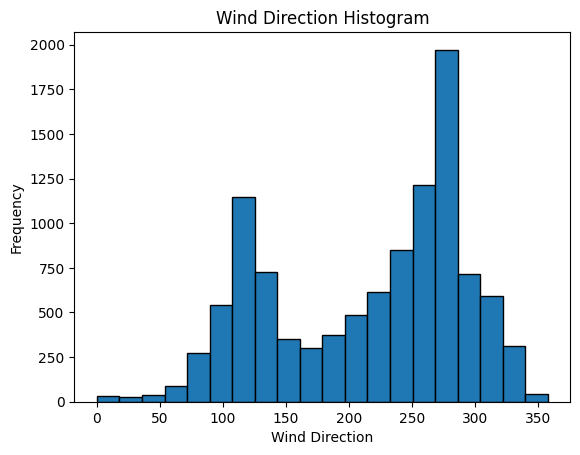

In [25]:
plt.hist(wind_dir, bins = 20, edgecolor = 'black')
plt.title('Wind Direction Histogram')
plt.xlabel('Wind Direction')
plt.ylabel('Frequency')
plt.savefig('Wind Direction Histogram.png')
#files.download('Wind Direction Histogram.png')
plt.show()

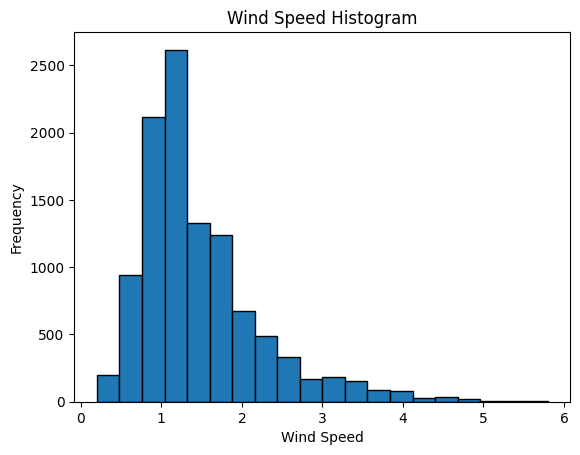

In [26]:
plt.hist(wind_speed, bins = 20, edgecolor = 'black')
plt.title('Wind Speed Histogram')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.savefig('Wind Speed Histogram.png')
#files.download('Wind Speed Histogram.png')
plt.show()

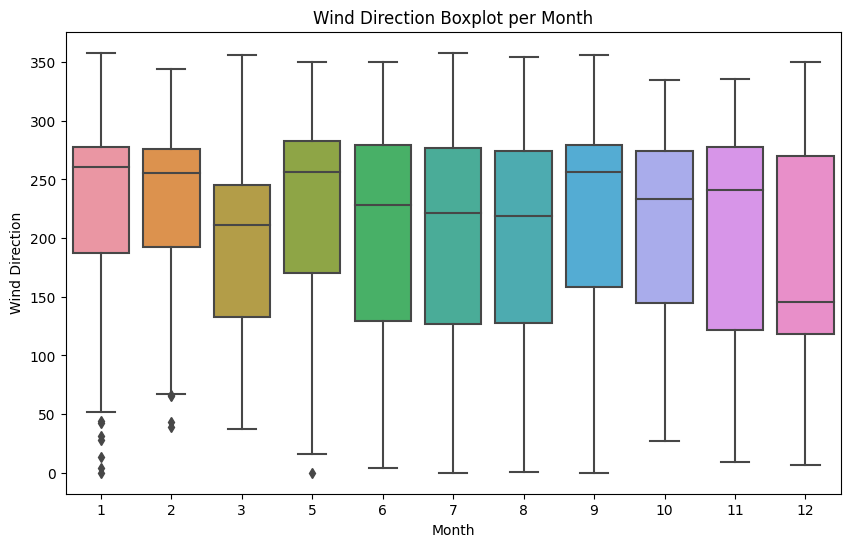

In [28]:
data_boxplot_wind_dir = {
    'Wind Direction': wind_dir,
    'Month': month_values_meteo
}

df = pd.DataFrame(data_boxplot_wind_dir)
# Create a boxplot per month using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Wind Direction', data=df)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Wind Direction')
plt.title('Wind Direction Boxplot per Month')

plt.savefig('Wind Direction Boxplot.png')
#files.download('Wind Direction Boxplot.png')
plt.show()

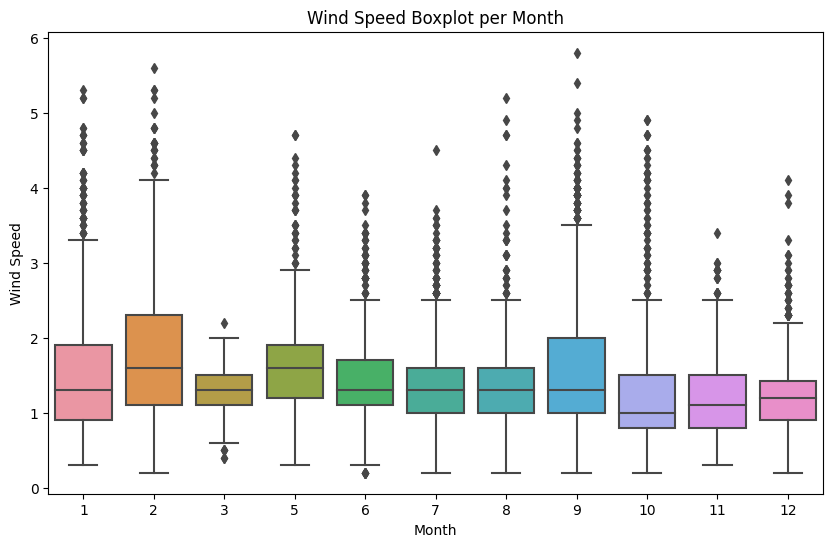

In [29]:
data_boxplot_wind_speed = {
    'Wind Speed': wind_speed,
    'Month': month_values_meteo
}

df = pd.DataFrame(data_boxplot_wind_speed)
# Create a boxplot per month using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Wind Speed', data=df)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Wind Speed')
plt.title('Wind Speed Boxplot per Month')

plt.savefig('Wind Speed Boxplot.png')
#files.download('Wind Speed Boxplot.png')
plt.show()

## Meteo Air Temperature

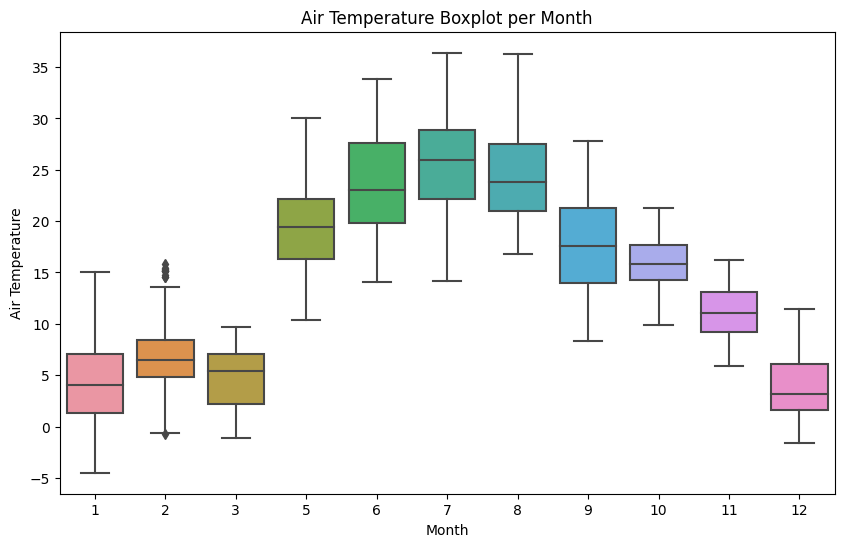

In [30]:
data_boxplot_air_temp = {
    'Air Temp': air_temp,
    'Month': month_values_meteo
}

df = pd.DataFrame(data_boxplot_air_temp)
# Create a boxplot per month using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Air Temp', data=df)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Air Temperature')
plt.title('Air Temperature Boxplot per Month')

plt.savefig('Air Temperature Boxplot.png')
#files.download('Air Temperature Boxplot.png')
plt.show()

## Meteo Time

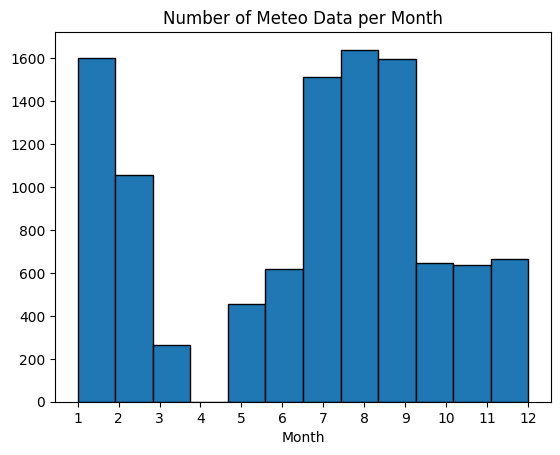

In [31]:
plt.hist(month_values_meteo, bins = 12, edgecolor = 'black')
plt.title('Number of Meteo Data per Month')
plt.xlabel('Month')
plt.xticks(range(1, 13))
plt.savefig('meteo_month_values.png')
#files.download('meteo_month_values.png')
